## Identifying Business-Oriented SAHM Creators Using Hashtag-Based Models 
---
**Author:** Ashley Cong
This notebook develops and evaluates three computational approaches—unsupervised clustering, rule-based classification, and supervised logistic regression—to identify entrepreneurial or business-oriented Stay-At-Home Mom (SAHM) creators on TikTok.

### Notebook Contents
1. [Setup & configuration](#1)
2. [Load and sample data](#2)
3. [Explanatory Data Analysis](#3)
4. [User and Hashtag Preprocessing](#4)
5. [TF-IDF Feature Construction](#5)
6. [Unsupervised Clustering(KMeans)](#6)
7. [Rule-Based Business Classification](#7)
8. [Preparing Labeled Data for Supervised Evaluation](#8)
9. [Approach 1 Evaluation: Clustering as a Classifier](#9)
10. [Approach 2 Evaluation: Rule-Based Performance](#10)
11. [Approach 3 Evaluation: Logistic Regression (Supervised Model)](#11)
12. [Full-Population Predictions](#12)
13. [Model Comparison and Summary Visualizations](#13)

<a id="1"></a>
### Setup & configuration

In [1]:
#Imports and basic setup

import os
import json
from collections import Counter, defaultdict
import duckdb

import numpy as np
import pandas as pd
from scipy import sparse

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score

<a id="2"></a>
### Data

In [2]:
import os
import duckdb

DUCKDB_PATH = "data/full_database.duckdb"
RAW_CSV_PATH = "data/raw.csv"

# Only export once (avoid lock issues + slow reruns)
if not os.path.exists(RAW_CSV_PATH):
    con = duckdb.connect(DUCKDB_PATH, read_only=True)  # read_only reduces lock headaches
    con.execute(f"COPY sahm TO '{RAW_CSV_PATH}' (FORMAT 'csv', HEADER TRUE)")
    con.close()
else:
    print(f"raw.csv already exists at {RAW_CSV_PATH}; skipping DuckDB export.")

raw.csv already exists at data/raw.csv; skipping DuckDB export.


In [3]:
DATA_DIR = "data/raw.csv"
labels_df = pd.read_csv("data/business_mom_labels.csv")
USER_POST_SUMMARY_PATH = "data/user_post_summary.csv"
HASHTAGS_30_USERS_PATH = "data/hashtags_more_than_30_users.csv"
US_HASHTAGS_SPLINTERED_PATH = "data/us_hashtags_splintered.csv"

In [4]:
MIN_POSTS_PER_USER = 5   # filter users who have at least this many posts
N_CLUSTERS_BIG = 100     # for initial many-cluster KMeans
N_CLUSTERS_BINARY = 2    # simple 2-cluster KMeans baseline

RANDOM_STATE = 42

<a id="3"></a>
### Explanatory Data Analysis

/var/folders/p8/m60mbpzs3hqd9jp5r1cwxrx00000gn/T/ipykernel_66914/784870516.py:28: UserWarning: Glyph 12471 (\N{KATAKANA LETTER SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/p8/m60mbpzs3hqd9jp5r1cwxrx00000gn/T/ipykernel_66914/784870516.py:28: UserWarning: Glyph 12442 (\N{COMBINING KATAKANA-HIRAGANA SEMI-VOICED SOUND MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/ashleycong/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12471 (\N{KATAKANA LETTER SI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ashleycong/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12442 (\N{COMBINING KATAKANA-HIRAGANA SEMI-VOICED SOUND MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


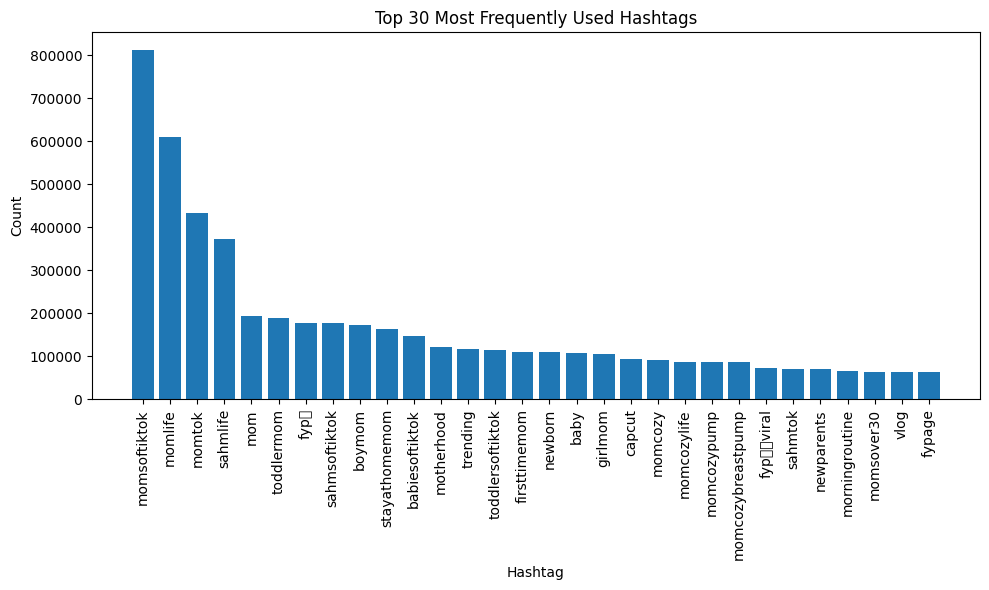

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming: hashtags_more_than_30_users.csv loaded into df_top
df_top = pd.read_csv("data/hashtags_more_than_30_users.csv")  # adjust path

EXCLUDE = {"sahm", "fyp", "foryou", "foryoupage", "viral"}

# Remove excluded hashtags (case-insensitive, with or without #)
df_top_filt = df_top[
    ~df_top["hashtag"]
    .str.lower()
    .str.replace("#", "", regex=False)
    .isin(EXCLUDE)
]

# Sort and select top 30 AFTER filtering
df_top_sorted = df_top_filt.sort_values(
    "hashtag_frequency", ascending=False
).head(30)

plt.figure(figsize=(10, 6))
plt.bar(df_top_sorted["hashtag"], df_top_sorted["hashtag_frequency"])
plt.xticks(rotation=90)
plt.title("Top 30 Most Frequently Used Hashtags")
plt.xlabel("Hashtag")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

<a id="4"></a>
### User and Hashtag Preprocessing

LOAD USER SUMMARY & FILTER USERS WITH ENOUGH POSTS

In [10]:
user_summary = pd.read_csv(USER_POST_SUMMARY_PATH)
# Filter users with enough posts
user_summary = user_summary.rename(columns={user_summary.columns[0]: "user_id"})
eligible_users = user_summary.loc[user_summary["total_posts"] >= MIN_POSTS_PER_USER].copy()
print(f"Total users in summary: {len(user_summary):,}")
print(f"Users with >= {MIN_POSTS_PER_USER} posts: {len(eligible_users):,}")
eligible_user_ids = set(eligible_users["user_id"].astype(str))

Total users in summary: 266,139
Users with >= 5 posts: 82,045


BUILD USER-HASHTAG COUNTS FROM hashtags_more_than_30_users.csv (HASHTAGS USED BY >= 30 USERS)

In [11]:
hashtags_df = pd.read_csv(HASHTAGS_30_USERS_PATH)
# Decide how many of the MOST frequently used tags to keep
TOP_N_HASHTAGS = 10_000
hashtags_top_df = hashtags_df.sort_values(
     "hashtag_frequency",
     ascending=False
 )

# Take the top N rows after sorting
hashtags_top_df = hashtags_top_df.head(TOP_N_HASHTAGS).copy()

# Normalize hashtag strings (lowercase, strip leading '#')
hashtags_top_df["hashtag_norm"] = (
    hashtags_top_df["hashtag"]
    .astype(str)
    .str.lower()
    .str.replace(r"^#", "", regex=True)
)

TOP_HASHTAG_SET = set(hashtags_top_df["hashtag_norm"])

In [12]:
import pandas as pd

MIN_POSTS_PER_USER = 5
user_summary = pd.read_csv(USER_POST_SUMMARY_PATH)

# Make sure first column is user_id (your file uses first column as username/userid)
user_summary = user_summary.rename(columns={user_summary.columns[0]: "user_id"})
user_summary["user_id"] = user_summary["user_id"].astype(str)

eligible_users = user_summary.loc[user_summary["total_posts"] >= MIN_POSTS_PER_USER].copy()
eligible_user_ids = set(eligible_users["user_id"])

print(f"Total users: {len(user_summary):,}")
print(f"Eligible users (>= {MIN_POSTS_PER_USER} posts): {len(eligible_users):,}")


Total users: 266,139
Eligible users (>= 5 posts): 82,045


<a id="5"></a>
### TF-IDF Feature Construction

CONSTRUCT USER x HASHTAG SPARSE MATRIX + TF-IDF

In [13]:
from collections import Counter
from sklearn.feature_extraction.text import TfidfTransformer
from scipy import sparse
import numpy as np
import pandas as pd

CHUNKSIZE = 1_000_000  # adjust if needed based on memory

print("\nBuilding per-user hashtag counts from:", US_HASHTAGS_SPLINTERED_PATH)

user_tag_counter = Counter()
seen_users = set()
seen_tags = set()

chunk_iter = pd.read_csv(US_HASHTAGS_SPLINTERED_PATH, chunksize=CHUNKSIZE)

for i, chunk in enumerate(chunk_iter):
    print(f"Processing chunk {i+1}...")

    # Ensure expected columns exist
    expected_cols = {"postid", "userid", "timestamp", "hashtag"}
    missing = expected_cols - set(chunk.columns)
    if missing:
        raise ValueError(f"us_hashtags_splintered.csv is missing columns: {missing}")

    # Normalize user_id
    chunk["userid"] = chunk["userid"].astype(str)

    # Filter to eligible users
    chunk = chunk[chunk["userid"].isin(eligible_user_ids)]
    if chunk.empty:
        continue

    # Normalize hashtags (lowercase, strip leading "#")
    chunk["hashtag_norm"] = (
        chunk["hashtag"].astype(str)
        .str.lower()
        .str.replace(r"^#", "", regex=True)
    )

    # Filter to top vocabulary
    chunk = chunk[chunk["hashtag_norm"].isin(TOP_HASHTAG_SET)]
    if chunk.empty:
        continue

    # Aggregate counts within this chunk
    # Each row is already "1 occurrence", but we'll groupby to reduce size
    grp = (
        chunk.groupby(["userid", "hashtag_norm"])
             .size()
             .reset_index(name="n_uses")
    )

    # Update global counters
    for _, row in grp.iterrows():
        key = (row["userid"], row["hashtag_norm"])
        user_tag_counter[key] += int(row["n_uses"])
        seen_users.add(row["userid"])
        seen_tags.add(row["hashtag_norm"])

print("\nFinished streaming us_hashtags_splintered.csv.")
print(f"Unique users with at least one top hashtag: {len(seen_users):,}")
print(f"Unique top hashtags actually used by these users: {len(seen_tags):,}")
print(f"Total (user, hashtag) pairs: {len(user_tag_counter):,}")

# ------------------------------------------------------------
# Build index mappings
# ------------------------------------------------------------

unique_users = sorted(seen_users)
unique_tags = sorted(seen_tags)

user_index = {u: i for i, u in enumerate(unique_users)}
tag_index = {t: j for j, t in enumerate(unique_tags)}

n_users = len(unique_users)
n_tags = len(unique_tags)

print(f"Building sparse matrix of shape (users x hashtags): {n_users} x {n_tags}")

# ------------------------------------------------------------
# Fill the sparse count matrix
# ------------------------------------------------------------

rows = []
cols = []
data_vals = []

for (u, t), c in user_tag_counter.items():
    rows.append(user_index[u])
    cols.append(tag_index[t])
    data_vals.append(float(c))

user_tag_counts = sparse.csr_matrix(
    (data_vals, (rows, cols)),
    shape=(n_users, n_tags),
    dtype=float
)

print("Non-zero entries in user_tag_counts:", user_tag_counts.nnz)

# ------------------------------------------------------------
# Compute TF-IDF
# ------------------------------------------------------------

tfidf_transformer = TfidfTransformer()
user_tag_tfidf = tfidf_transformer.fit_transform(user_tag_counts)

print("TF-IDF matrix built:", user_tag_tfidf.shape)

# Inverse mapping for later cluster inspection
inv_tag_index = {j: t for t, j in tag_index.items()}


Building per-user hashtag counts from: data/us_hashtags_splintered.csv
Processing chunk 1...


/var/folders/p8/m60mbpzs3hqd9jp5r1cwxrx00000gn/T/ipykernel_66914/2426428319.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["hashtag_norm"] = (


Processing chunk 2...


/var/folders/p8/m60mbpzs3hqd9jp5r1cwxrx00000gn/T/ipykernel_66914/2426428319.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["hashtag_norm"] = (


Processing chunk 3...


/var/folders/p8/m60mbpzs3hqd9jp5r1cwxrx00000gn/T/ipykernel_66914/2426428319.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["hashtag_norm"] = (


Processing chunk 4...


/var/folders/p8/m60mbpzs3hqd9jp5r1cwxrx00000gn/T/ipykernel_66914/2426428319.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["hashtag_norm"] = (


Processing chunk 5...


/var/folders/p8/m60mbpzs3hqd9jp5r1cwxrx00000gn/T/ipykernel_66914/2426428319.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["hashtag_norm"] = (


Processing chunk 6...


/var/folders/p8/m60mbpzs3hqd9jp5r1cwxrx00000gn/T/ipykernel_66914/2426428319.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["hashtag_norm"] = (


Processing chunk 7...


/var/folders/p8/m60mbpzs3hqd9jp5r1cwxrx00000gn/T/ipykernel_66914/2426428319.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["hashtag_norm"] = (


Processing chunk 8...


/var/folders/p8/m60mbpzs3hqd9jp5r1cwxrx00000gn/T/ipykernel_66914/2426428319.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["hashtag_norm"] = (


Processing chunk 9...


/var/folders/p8/m60mbpzs3hqd9jp5r1cwxrx00000gn/T/ipykernel_66914/2426428319.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["hashtag_norm"] = (


Processing chunk 10...


/var/folders/p8/m60mbpzs3hqd9jp5r1cwxrx00000gn/T/ipykernel_66914/2426428319.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["hashtag_norm"] = (


Processing chunk 11...


/var/folders/p8/m60mbpzs3hqd9jp5r1cwxrx00000gn/T/ipykernel_66914/2426428319.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["hashtag_norm"] = (


Processing chunk 12...


/var/folders/p8/m60mbpzs3hqd9jp5r1cwxrx00000gn/T/ipykernel_66914/2426428319.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["hashtag_norm"] = (


Processing chunk 13...


/var/folders/p8/m60mbpzs3hqd9jp5r1cwxrx00000gn/T/ipykernel_66914/2426428319.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["hashtag_norm"] = (


Processing chunk 14...


/var/folders/p8/m60mbpzs3hqd9jp5r1cwxrx00000gn/T/ipykernel_66914/2426428319.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["hashtag_norm"] = (


Processing chunk 15...


/var/folders/p8/m60mbpzs3hqd9jp5r1cwxrx00000gn/T/ipykernel_66914/2426428319.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["hashtag_norm"] = (


Processing chunk 16...


/var/folders/p8/m60mbpzs3hqd9jp5r1cwxrx00000gn/T/ipykernel_66914/2426428319.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["hashtag_norm"] = (


Processing chunk 17...


/var/folders/p8/m60mbpzs3hqd9jp5r1cwxrx00000gn/T/ipykernel_66914/2426428319.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["hashtag_norm"] = (


Processing chunk 18...


/var/folders/p8/m60mbpzs3hqd9jp5r1cwxrx00000gn/T/ipykernel_66914/2426428319.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["hashtag_norm"] = (


Processing chunk 19...


/var/folders/p8/m60mbpzs3hqd9jp5r1cwxrx00000gn/T/ipykernel_66914/2426428319.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["hashtag_norm"] = (


Processing chunk 20...


/var/folders/p8/m60mbpzs3hqd9jp5r1cwxrx00000gn/T/ipykernel_66914/2426428319.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["hashtag_norm"] = (


Processing chunk 21...


/var/folders/p8/m60mbpzs3hqd9jp5r1cwxrx00000gn/T/ipykernel_66914/2426428319.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["hashtag_norm"] = (


Processing chunk 22...


/var/folders/p8/m60mbpzs3hqd9jp5r1cwxrx00000gn/T/ipykernel_66914/2426428319.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["hashtag_norm"] = (


Processing chunk 23...


/var/folders/p8/m60mbpzs3hqd9jp5r1cwxrx00000gn/T/ipykernel_66914/2426428319.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["hashtag_norm"] = (


Processing chunk 24...


/var/folders/p8/m60mbpzs3hqd9jp5r1cwxrx00000gn/T/ipykernel_66914/2426428319.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["hashtag_norm"] = (


Processing chunk 25...


/var/folders/p8/m60mbpzs3hqd9jp5r1cwxrx00000gn/T/ipykernel_66914/2426428319.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["hashtag_norm"] = (


Processing chunk 26...


/var/folders/p8/m60mbpzs3hqd9jp5r1cwxrx00000gn/T/ipykernel_66914/2426428319.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["hashtag_norm"] = (


Processing chunk 27...


/var/folders/p8/m60mbpzs3hqd9jp5r1cwxrx00000gn/T/ipykernel_66914/2426428319.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["hashtag_norm"] = (


Processing chunk 28...


/var/folders/p8/m60mbpzs3hqd9jp5r1cwxrx00000gn/T/ipykernel_66914/2426428319.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["hashtag_norm"] = (



Finished streaming us_hashtags_splintered.csv.
Unique users with at least one top hashtag: 75,432
Unique top hashtags actually used by these users: 9,999
Total (user, hashtag) pairs: 4,667,259
Building sparse matrix of shape (users x hashtags): 75432 x 9999
Non-zero entries in user_tag_counts: 4667259
TF-IDF matrix built: (75432, 9999)


<a id="6"></a>
### Unsupervised Clustering (KMeans)

UNSUPERVISED CLUSTERING APPROACHES (K-MEANS)

In [16]:
# ------------------------------------------------------------
# 4.1 Many-cluster approach (e.g., 100 clusters)
# ------------------------------------------------------------
big_kmeans = MiniBatchKMeans(
    n_clusters=N_CLUSTERS_BIG,
    random_state=RANDOM_STATE,
    batch_size=2048,
    max_iter=200
)
big_cluster_labels = big_kmeans.fit_predict(user_tag_tfidf)


In [17]:
from collections import Counter
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import (
    classification_report, roc_auc_score, confusion_matrix,
    f1_score, precision_recall_fscore_support, adjusted_rand_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score


In [18]:
# Seed business/entrepreneurial hashtags
BUSINESS_HASHTAG_SEEDS = {
    "smallbusiness", "smallbiz", "mompreneur", "bossmom",
    "bossbabe", "sidehustle", "sidehustles", "entrepreneur",
    "entrepreneurlife", "business", "businessowner", "coaching",
    "contentcreator", "brand", "branding", "workfromhome",
    "workingmom", "digitalmarketing", "wfhm", "work", "wfhmom",
    "bluecollarwife", "workfromhomemom"
}

business_seed_set = {h.lower().lstrip("#") for h in BUSINESS_HASHTAG_SEEDS}

Manually labeled N creators as business-oriented or not. After restricting to users with at least MIN_POSTS_PER_USER and at least one hashtag in the top hashtag vocabulary, M labeled creators remained and were used for training and evaluation.

<a id="7"></a>
### Rule-Based Business Classification

In [23]:
import numpy as np
import pandas as pd

# Ensure business hashtags are lowercase
BUSINESS_HASHTAG_SEEDS = {h.lower() for h in BUSINESS_HASHTAG_SEEDS}

# Identify TF-IDF columns corresponding to business hashtags
business_cols = [
    idx for idx, tag in inv_tag_index.items()
    if tag.lower() in BUSINESS_HASHTAG_SEEDS
]

print(f"Number of business hashtag columns: {len(business_cols)}")

# Sum TF-IDF weights per user
total_tfidf = np.asarray(user_tag_tfidf.sum(axis=1)).ravel()
business_tfidf = (
    np.asarray(user_tag_tfidf[:, business_cols].sum(axis=1)).ravel()
    if business_cols else np.zeros_like(total_tfidf)
)

rule_df = pd.DataFrame({
    "user_id": [str(u) for u in unique_users],
    "total_hashtag_tfidf": total_tfidf,
    "business_hashtag_tfidf": business_tfidf,
    "business_hashtag_prop": np.divide(
        business_tfidf,
        total_tfidf,
        out=np.zeros_like(business_tfidf),
        where=total_tfidf > 0
    )
})

print("rule_df shape:", rule_df.shape)
print(rule_df.head())


Number of business hashtag columns: 23
rule_df shape: (75432, 4)
         user_id  total_hashtag_tfidf  business_hashtag_tfidf  \
0      ...elitea             6.666753                0.000000   
1     ...justme5             5.153544                0.221197   
2    ..jazzy__._             6.140105                0.000000   
3  ..kaitlynn..b             3.292425                0.002316   
4     ..kamrm710             5.914642                0.000000   

   business_hashtag_prop  
0               0.000000  
1               0.042921  
2               0.000000  
3               0.000703  
4               0.000000  


In [24]:
# Merge labels with rule-based scores and cluster assignments
labeled_meta = (
    labels_df[["user_id", "label"]]
    .merge(rule_df, on="user_id", how="left")
    .merge(cluster_binary_df, on="user_id", how="left")
    .merge(eligible_users[["user_id", "total_posts"]], on="user_id", how="left")
)

print("\nLabeled users with merged metadata:")
print(labeled_meta.head())


Labeled users with merged metadata:
         user_id        label  total_hashtag_tfidf  business_hashtag_tfidf  \
0     dynalady52  nonbusiness                  NaN                     NaN   
1      courtbee6  nonbusiness                  NaN                     NaN   
2  princessb0240  nonbusiness                  NaN                     NaN   
3  leslie_momof3  nonbusiness                  NaN                     NaN   
4  dollypink0907  nonbusiness                  NaN                     NaN   

   business_hashtag_prop  cluster_binary  total_posts  
0                    NaN             NaN          NaN  
1                    NaN             NaN          NaN  
2                    NaN             NaN          NaN  
3                    NaN             NaN          NaN  
4                    NaN             NaN          NaN  


<a id="8"></a>
### Preparing Labeled Data for Supervised Evaluation

In [56]:
# Make sure IDs are strings
labeled_meta["user_id"] = labeled_meta["user_id"].astype(str)

# Only keep labeled users that are present in the TF-IDF matrix
available_ids = set(user_index.keys())
labeled_meta_tfidf = labeled_meta[labeled_meta["user_id"].isin(available_ids)].copy()

dropped = len(labeled_meta) - len(labeled_meta_tfidf)
print(f"Labeled users total: {len(labeled_meta)}")
print(f"Labeled users with TF-IDF features: {len(labeled_meta_tfidf)}")
print(f"Labeled users dropped (no top hashtags / not eligible): {dropped}")

# Now build indices only for the filtered labeled users
labeled_user_ids = labeled_meta_tfidf["user_id"].tolist()
labeled_indices = [user_index[u] for u in labeled_user_ids]

labeled_meta_tfidf["label"] = (
    labeled_meta_tfidf["label"].astype(str).str.lower()
    .map({"business": 1, "nonbusiness": 0})
)

if labeled_meta_tfidf["label"].isna().any():
    raise ValueError("Unmapped labels found: " +
                     str(labeled_meta_tfidf.loc[labeled_meta_tfidf["label"].isna(), "label"].unique()))

labeled_meta_tfidf["label"] = labeled_meta_tfidf["label"].astype(int)


X = user_tag_tfidf[labeled_indices, :]
y = labeled_meta_tfidf["label"].values

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, np.arange(len(y)),
    test_size=0.3,
    random_state=RANDOM_STATE,
    stratify=y
)

# 3A. Logistic Regression
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1
)
log_reg.fit(X_train, y_train)

y_pred_lr = log_reg.predict(X_test)
y_proba_lr = log_reg.predict_proba(X_test)[:, 1]

print("\n=== Logistic Regression (Approach 3) on labeled subset ===")
print(classification_report(y_test, y_pred_lr, digits=3))
print("ROC AUC:", roc_auc_score(y_test, y_proba_lr))

# 3B. Optional KNN
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
y_proba_knn = knn.predict_proba(X_test)[:, 1]

print("\n=== KNN (k=5, optional) on labeled subset ===")
print(classification_report(y_test, y_pred_knn, digits=3))
print("ROC AUC:", roc_auc_score(y_test, y_proba_knn))

# 5-fold CV F1 for LR (for robustness)
cv_scores = cross_val_score(log_reg, X, y, cv=5, scoring="f1")
print("\nLogistic Regression 5-fold CV F1 scores:", cv_scores, "mean:", cv_scores.mean())

Labeled users total: 60
Labeled users with TF-IDF features: 32
Labeled users dropped (no top hashtags / not eligible): 28

=== Logistic Regression (Approach 3) on labeled subset ===
              precision    recall  f1-score   support

           0      0.625     0.833     0.714         6
           1      0.500     0.250     0.333         4

    accuracy                          0.600        10
   macro avg      0.562     0.542     0.524        10
weighted avg      0.575     0.600     0.562        10

ROC AUC: 0.8333333333333334

=== KNN (k=5, optional) on labeled subset ===
              precision    recall  f1-score   support

           0      1.000     0.833     0.909         6
           1      0.800     1.000     0.889         4

    accuracy                          0.900        10
   macro avg      0.900     0.917     0.899        10
weighted avg      0.920     0.900     0.901        10

ROC AUC: 0.8749999999999999

Logistic Regression 5-fold CV F1 scores: [0.66666667 0.4    

<a id="9"></a>
### Approach 1:Clustering (unsupervised)
1. Big KMeans (100 clusters) to discover content “types” and inspect cluster centers.
2. Binary KMeans (2 clusters) as a primitive classifier: one cluster ≈ business, one ≈ non-business.
3. Map cluster IDs → business / non-business using your manual labels (so we can score this approach).

In [58]:
from sklearn.metrics import classification_report, f1_score, adjusted_rand_score
import pandas as pd

# 0) Start from a clean labeled frame
labeled_meta_cluster = labeled_meta_tfidf.copy()
labeled_meta_cluster["user_id"] = labeled_meta_cluster["user_id"].astype(str)

# 1) Ensure your ground-truth label column is numeric and correct
if "label_binary" in labeled_meta_cluster.columns:
    y_col = "label_binary"
else:
    y_col = "label"
    tmp = labeled_meta_cluster["label"].astype(str).str.lower().str.strip()

    # Case A: already binary but stored as strings "0"/"1"
    if set(tmp.unique()) <= {"0", "1"}:
        labeled_meta_cluster["label_binary"] = tmp.astype(int)
        y_col = "label_binary"

    # Case B: text labels
    elif set(tmp.unique()) <= {"business", "nonbusiness"}:
        labeled_meta_cluster["label_binary"] = tmp.map({"business": 1, "nonbusiness": 0}).astype(int)
        y_col = "label_binary"

    else:
        raise ValueError(f"'label' has unexpected values: {sorted(set(tmp.unique()))}")

labeled_meta_cluster[y_col] = labeled_meta_cluster[y_col].astype(int)
# 2) CLEAN OUT any prior cluster columns to avoid _x/_y suffix mess
for c in ["cluster_binary", "cluster_binary_x", "cluster_binary_y", "pred_cluster_binary"]:
    if c in labeled_meta_cluster.columns:
        labeled_meta_cluster = labeled_meta_cluster.drop(columns=[c])

# 3) Standardize cluster_binary_df columns (handles cluster / label / etc.)
cb = cluster_binary_df.copy()

id_candidates = ["user_id", "userid", "user", "username"]
id_col = next((c for c in id_candidates if c in cb.columns), None)
if id_col is None:
    raise ValueError(f"cluster_binary_df missing user id column; tried {id_candidates}")

cluster_candidates = ["cluster_binary", "cluster", "label"]
cluster_col = next((c for c in cluster_candidates if c in cb.columns), None)
if cluster_col is None:
    raise ValueError(f"cluster_binary_df missing cluster column; tried {cluster_candidates}")

cb = cb.rename(columns={id_col: "user_id", cluster_col: "cluster_binary"})
cb["user_id"] = cb["user_id"].astype(str)

# 4) Merge in cluster labels (inner ensures only overlapping users)
labeled_meta_cluster = labeled_meta_cluster.merge(
    cb[["user_id", "cluster_binary"]],
    on="user_id",
    how="inner"
)

print("After merge rows:", len(labeled_meta_cluster))
print("Columns now:", list(labeled_meta_cluster.columns))

# HARD STOP if merge didn’t add the column
if "cluster_binary" not in labeled_meta_cluster.columns:
    raise ValueError(
        "cluster_binary still missing after merge. "
        "This usually means cluster_binary_df didn't have the right column, "
        "or you merged earlier and created suffix columns."
    )

# HARD STOP if no overlap
if labeled_meta_cluster.empty:
    raise ValueError(
        "No overlap between labeled_meta_tfidf and cluster_binary_df. "
        "Check that clustering ran on the same user set and user_id strings match."
    )

labeled_meta_cluster["cluster_binary"] = labeled_meta_cluster["cluster_binary"].astype(int)

# 5) Map cluster → business using labeled prevalence
cluster_means = labeled_meta_cluster.groupby("cluster_binary")[y_col].mean()
print("Mean business rate per cluster:\n", cluster_means)

business_cluster = int(cluster_means.idxmax())
cluster_to_business = {0: 0, 1: 0}
cluster_to_business[business_cluster] = 1

labeled_meta_cluster["pred_cluster_binary"] = labeled_meta_cluster["cluster_binary"].map(cluster_to_business).astype(int)

# 6) Evaluate
y_true = labeled_meta_cluster[y_col].values
y_pred = labeled_meta_cluster["pred_cluster_binary"].values

print("\n=== Approach 1: Clustering (2-cluster mapped) ===")
print(classification_report(y_true, y_pred, digits=3))

print("F1:", f1_score(y_true, y_pred))
print("ARI:", adjusted_rand_score(y_true, labeled_meta_cluster["cluster_binary"].values))


After merge rows: 32
Columns now: ['user_id', 'label', 'total_hashtag_tfidf', 'business_hashtag_tfidf', 'business_hashtag_prop', 'total_posts', 'label_binary', 'cluster_binary']
Mean business rate per cluster:
 cluster_binary
0    0.200000
1    0.545455
Name: label_binary, dtype: float64

=== Approach 1: Clustering (2-cluster mapped) ===
              precision    recall  f1-score   support

           0      0.800     0.444     0.571        18
           1      0.545     0.857     0.667        14

    accuracy                          0.625        32
   macro avg      0.673     0.651     0.619        32
weighted avg      0.689     0.625     0.613        32

F1: 0.6666666666666666
ARI: 0.03401713840560893


<a id="10"></a>
### Approach 2: Rule-based Business Score
Use seed hashtags to compute:

1. Business_hashtag_uses: how many times that user used any business seed hashtag.
2. Business_hashtag_prop: proportion of their hashtag uses that are business-seed.
3. Define a threshold (tuned later on labeled data) to classify.

In [59]:
# find which columns of user_tag_counts correspond to business seed tags
business_tag_indices = [
    tag_index[t] for t in business_seed_set if t in tag_index
]

print(f"Seed business hashtags found in vocabulary: {len(business_tag_indices)}")

total_counts_per_user = np.array(user_tag_counts.sum(axis=1)).ravel()
business_counts_per_user = np.array(
    user_tag_counts[:, business_tag_indices].sum(axis=1)
).ravel()

business_prop_per_user = np.divide(
    business_counts_per_user,
    total_counts_per_user,
    out=np.zeros_like(business_counts_per_user, dtype=float),
    where=total_counts_per_user > 0
)

rule_df = pd.DataFrame({
    "user_id": unique_users,
    "total_hashtag_uses": total_counts_per_user,
    "business_hashtag_uses": business_counts_per_user,
    "business_hashtag_prop": business_prop_per_user
})

# Initial naive threshold (we'll tune it using labeled data)
BUSINESS_PROP_THRESHOLD = 0.05   # 5% of their hashtags are "business seeds"
rule_df["rule_is_business"] = (rule_df["business_hashtag_prop"] >= BUSINESS_PROP_THRESHOLD).astype(int)

print("\nRule-based label counts (initial threshold):")
print(rule_df["rule_is_business"].value_counts())


Seed business hashtags found in vocabulary: 23

Rule-based label counts (initial threshold):
rule_is_business
0    65587
1     9845
Name: count, dtype: int64


<a id="11"></a>
### Approach 3: Supervised Logistic Regression and KNN

In [60]:
MANUAL_LABELS_PATH = "data/business_mom_labels.csv"

labels_df = pd.read_csv(MANUAL_LABELS_PATH)
labels_df["user_id"] = labels_df["user_id"].astype(str)

label_map = {
    "business": 1,
    "nonbusiness": 0,
    1: 1,
    0: 0
}
labels_df["label_binary"] = labels_df["label"].map(label_map)

print("\nManual label distribution:")
print(labels_df["label_binary"].value_counts())



Manual label distribution:
label_binary
0    33
1    27
Name: count, dtype: int64


### EVALUATE APPROACH 1 – CLUSTERING (2-Cluster KMeans)

In [63]:
# 0) Make sure labeled_meta_tfidf already exists from the LR/KNN setup cell
# and contains: user_id, label_binary

# 1) Standardize column names in cluster_binary_df
print("cluster_binary_df columns:", list(cluster_binary_df.columns))

# detect ID column
cb_id_candidates = ["user_id", "userid", "user", "username"]
cb_id_col = None
for c in cb_id_candidates:
    if c in cluster_binary_df.columns:
        cb_id_col = c
        break

if cb_id_col is None:
    raise ValueError(
        f"Could not find a user ID column in cluster_binary_df. "
        f"Tried: {cb_id_candidates}"
    )

# detect cluster column
cb_cluster_candidates = ["cluster_binary", "cluster", "label"]
cb_cluster_col = None
for c in cb_cluster_candidates:
    if c in cluster_binary_df.columns:
        cb_cluster_col = c
        break

if cb_cluster_col is None:
    raise ValueError(
        f"Could not find a cluster label column in cluster_binary_df. "
        f"Tried: {cb_cluster_candidates}"
    )

# rename to standard names
cluster_binary_df_std = cluster_binary_df.rename(columns={
    cb_id_col: "user_id",
    cb_cluster_col: "cluster_binary"
}).copy()

cluster_binary_df_std["user_id"] = cluster_binary_df_std["user_id"].astype(str)

print("Standardized cluster_binary_df columns:", list(cluster_binary_df_std.columns))

# --- NEW: drop any existing cluster-related columns so re-running is safe ---
for col in ["cluster_binary", "cluster_binary_x", "cluster_binary_y", "pred_cluster_binary"]:
    if col in labeled_meta_tfidf.columns:
        labeled_meta_tfidf = labeled_meta_tfidf.drop(columns=[col])

# 2) Merge cluster labels into labeled_meta_tfidf
labeled_meta_tfidf = labeled_meta_tfidf.merge(
    cluster_binary_df_std[["user_id", "cluster_binary"]],
    on="user_id",
    how="left"
)

print("labeled_meta_tfidf columns after merge:", list(labeled_meta_tfidf.columns))

# 3) Compute which cluster is the 'business' cluster
cluster_means = labeled_meta_tfidf.groupby("cluster_binary")["label"].mean()
print("\nMean true 'business' probability per cluster:")
print(cluster_means)

business_cluster = cluster_means.idxmax()
cluster_to_business = {0: 0, 1: 0}
cluster_to_business[business_cluster] = 1
print("\nCluster → business mapping:", cluster_to_business)

# 4) Apply mapping to get predicted business label
labeled_meta_tfidf["pred_cluster_binary"] = labeled_meta_tfidf["cluster_binary"].map(cluster_to_business)

# 5) Drop any rows missing cluster labels (rare)
cluster_eval = labeled_meta_tfidf.dropna(subset=["cluster_binary", "pred_cluster_binary"]).copy()

cluster_eval["cluster_binary"] = cluster_eval["cluster_binary"].astype(int)
cluster_eval["pred_cluster_binary"] = cluster_eval["pred_cluster_binary"].astype(int)
cluster_eval["label"] = cluster_eval["label"].astype(int)

print("\nLabeled users with TF-IDF + cluster labels:", len(cluster_eval))

print("\n=== Approach 1: 2-Cluster KMeans (mapped) ===")
print(classification_report(
    cluster_eval["label"],
    cluster_eval["pred_cluster_binary"],
    digits=3
))

f1_cluster = f1_score(cluster_eval["label"], cluster_eval["pred_cluster_binary"])
print("F1 (cluster):", f1_cluster)

cluster_binary_df columns: ['user_id', 'cluster_binary']
Standardized cluster_binary_df columns: ['user_id', 'cluster_binary']
labeled_meta_tfidf columns after merge: ['user_id', 'label', 'total_hashtag_tfidf', 'business_hashtag_tfidf', 'business_hashtag_prop', 'total_posts', 'cluster_binary']

Mean true 'business' probability per cluster:
cluster_binary
0    0.200000
1    0.545455
Name: label, dtype: float64

Cluster → business mapping: {0: 0, 1: 1}

Labeled users with TF-IDF + cluster labels: 32

=== Approach 1: 2-Cluster KMeans (mapped) ===
              precision    recall  f1-score   support

           0      0.800     0.444     0.571        18
           1      0.545     0.857     0.667        14

    accuracy                          0.625        32
   macro avg      0.673     0.651     0.619        32
weighted avg      0.689     0.625     0.613        32

F1 (cluster): 0.6666666666666666


### EVALUATE APPROACH 2 – RULE-BASED (BUSINESS HASHTAG PROP)

In [65]:
if "business_hashtag_prop" not in labeled_meta_tfidf.columns:
    labeled_meta_tfidf = labeled_meta_tfidf.merge(
        rule_df[["user_id", "business_hashtag_prop"]],
        on="user_id",
        how="left"
    )

y_true_rule = labeled_meta_tfidf["label"].values
props = labeled_meta_tfidf["business_hashtag_prop"].fillna(0).values

# Grid search threshold to maximize F1
thresholds = np.linspace(0.0, 0.20, 41)  # 0.000, 0.005, ..., 0.200
best_f1 = -1
best_thresh = None

for t in thresholds:
    y_pred_rule = (props >= t).astype(int)
    f1 = f1_score(y_true_rule, y_pred_rule)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print("\nBest rule-based threshold:", best_thresh, "with F1:", best_f1)

# Final rule-based predictions at best threshold
labeled_meta_tfidf["pred_rule"] = (labeled_meta_tfidf["business_hashtag_prop"].fillna(0) >= best_thresh).astype(int)

print("\n=== Approach 2: Rule-based (best threshold) on labeled subset ===")
print(classification_report(
    labeled_meta_tfidf["label"],
    labeled_meta_tfidf["pred_rule"],
    digits=3
))
f1_rule = f1_score(labeled_meta_tfidf["label"], labeled_meta_tfidf["pred_rule"])
print("F1 (rule-based):", f1_rule)


Best rule-based threshold: 0.015 with F1: 0.75

=== Approach 2: Rule-based (best threshold) on labeled subset ===
              precision    recall  f1-score   support

           0      0.857     0.667     0.750        18
           1      0.667     0.857     0.750        14

    accuracy                          0.750        32
   macro avg      0.762     0.762     0.750        32
weighted avg      0.774     0.750     0.750        32

F1 (rule-based): 0.75


### EVALUATE APPROACH 3 – LOGISTIC REGRESSION (+ optional KNN)

In [66]:
# X, y already built from labeled_meta_tfidf and user_tag_tfidf
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, np.arange(len(y)),
    test_size=0.3,
    random_state=RANDOM_STATE,
    stratify=y
)

# 3A. Logistic Regression
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1
)
log_reg.fit(X_train, y_train)

y_pred_lr = log_reg.predict(X_test)
y_proba_lr = log_reg.predict_proba(X_test)[:, 1]

print("\n=== Approach 3: Logistic Regression on labeled subset ===")
print(classification_report(y_test, y_pred_lr, digits=3))
print("ROC AUC (LR test):", roc_auc_score(y_test, y_proba_lr))

# 3B. Optional KNN
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
y_proba_knn = knn.predict_proba(X_test)[:, 1]

print("\n=== KNN (k=5, optional) on labeled subset ===")
print(classification_report(y_test, y_pred_knn, digits=3))
print("ROC AUC (KNN test):", roc_auc_score(y_test, y_proba_knn))

# 5-fold CV F1 for LR (for robustness)
cv_scores = cross_val_score(log_reg, X, y, cv=5, scoring="f1")
print("\nLogistic Regression 5-fold CV F1 scores:", cv_scores, "mean:", cv_scores.mean())


=== Approach 3: Logistic Regression on labeled subset ===
              precision    recall  f1-score   support

           0      0.625     0.833     0.714         6
           1      0.500     0.250     0.333         4

    accuracy                          0.600        10
   macro avg      0.562     0.542     0.524        10
weighted avg      0.575     0.600     0.562        10

ROC AUC (LR test): 0.8333333333333334

=== KNN (k=5, optional) on labeled subset ===
              precision    recall  f1-score   support

           0      1.000     0.833     0.909         6
           1      0.800     1.000     0.889         4

    accuracy                          0.900        10
   macro avg      0.900     0.917     0.899        10
weighted avg      0.920     0.900     0.901        10

ROC AUC (KNN test): 0.8749999999999999

Logistic Regression 5-fold CV F1 scores: [0.66666667 0.4        0.5        1.         0.5       ] mean: 0.6133333333333333


### Approach 4

In [70]:
from sentence_transformers import SentenceTransformer

TEXT_CSV_PATH = "data/raw.csv"
CHUNKSIZE = 200_000

user_texts = {}  # username -> list of captions

cols_needed = ["username", "video_description"]

for chunk in pd.read_csv(TEXT_CSV_PATH, usecols=cols_needed, chunksize=CHUNKSIZE):
    # drop missing text
    chunk = chunk.dropna(subset=["username", "video_description"])
    chunk["username"] = chunk["username"].astype(str)
    chunk["video_description"] = chunk["video_description"].astype(str)

    # group within chunk to avoid Python-level loops
    grp = (
        chunk.groupby("username")["video_description"]
        .apply(lambda s: " ".join(s.tolist()))
    )

    for uid, text in grp.items():
        if uid not in user_texts:
            user_texts[uid] = []
        user_texts[uid].append(text)

# collapse to a single document per user (concatenate all chunk-level strings)
user_text_docs = {uid: " ".join(snippets) for uid, snippets in user_texts.items()}

print("Users with at least one caption:", len(user_text_docs))

# ------------------------------------------------------------
# 2. Align with manual labels (labels_df must already exist)
#    labels_df: columns ["user_id", "label_binary"]
# ------------------------------------------------------------

labels_df["user_id"] = labels_df["user_id"].astype(str)

labels_text = labels_df[labels_df["user_id"].isin(user_text_docs.keys())].copy()
labels_text["text_doc"] = labels_text["user_id"].map(user_text_docs)

print("Labeled users total:", len(labels_df))
print("Labeled users with caption docs:", len(labels_text))
print(labels_text.head())

# ------------------------------------------------------------
# 3. Encode text docs with a small transformer (fast)
# ------------------------------------------------------------

model_name = "sentence-transformers/all-MiniLM-L6-v2"  # small & fast
sbert_model = SentenceTransformer(model_name)

texts = labels_text["text_doc"].tolist()
batch_size = 64

text_embeddings = sbert_model.encode(
    texts,
    batch_size=batch_size,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True,
)

print("Embeddings shape:", text_embeddings.shape)

X_text = text_embeddings
y_text = labels_text["label_binary"].values

# ------------------------------------------------------------
# 4. Train / evaluate logistic regression on text embeddings
# ------------------------------------------------------------

X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(
    X_text,
    y_text,
    test_size=0.3,
    random_state=42,
    stratify=y_text,
)

log_reg_text = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    n_jobs=-1,
)
log_reg_text.fit(X_train_t, y_train_t)

y_pred_text = log_reg_text.predict(X_test_t)
y_proba_text = log_reg_text.predict_proba(X_test_t)[:, 1]

print("\n=== Approach 4: Transformer Captions + Logistic Regression ===")
print(classification_report(y_test_t, y_pred_text, digits=3))
print("ROC AUC (text LR):", roc_auc_score(y_test_t, y_proba_text))

cv_scores_text = cross_val_score(
    log_reg_text,
    X_text,
    y_text,
    cv=5,
    scoring="f1",
)
print("5-fold CV F1 (text LR):", cv_scores_text, "mean:", cv_scores_text.mean())

all_user_ids_text = list(user_text_docs.keys())
all_texts = [user_text_docs[uid] for uid in all_user_ids_text]

all_embeddings = sbert_model.encode(
    all_texts,
    batch_size=batch_size,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True,
)

all_proba_text = log_reg_text.predict_proba(all_embeddings)[:, 1]
all_pred_text = (all_proba_text >= 0.5).astype(int)

results_text_all = pd.DataFrame({
    "user_id": all_user_ids_text,
    "pred_text_business_label": all_pred_text,
    "pred_text_business_proba": all_proba_text,
})

print("\nSample of transformer-based predictions:")
print(results_text_all.head())


Users with at least one caption: 266134
Labeled users total: 60
Labeled users with caption docs: 60
         user_id        label  label_binary  \
0     dynalady52  nonbusiness             0   
1      courtbee6  nonbusiness             0   
2  princessb0240  nonbusiness             0   
3  leslie_momof3  nonbusiness             0   
4  dollypink0907  nonbusiness             0   

                                            text_doc  
0  #bored #snapyourlife #thesebootsthough #merica...  
1  I know it says kicked but I’d rather not get k...  
2  #SAHM #MomofBoth When the 11mo old falls aslee...  
3                 she was doing it tooo lol... #sahm  
4  @fangirlx8 #wahm #sahm #wingeyeliner #tattooed...  


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

Embeddings shape: (60, 384)



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The


=== Approach 4: Transformer Captions + Logistic Regression ===
              precision    recall  f1-score   support

           0      0.727     0.800     0.762        10
           1      0.714     0.625     0.667         8

    accuracy                          0.722        18
   macro avg      0.721     0.713     0.714        18
weighted avg      0.722     0.722     0.720        18

ROC AUC (text LR): 0.875
5-fold CV F1 (text LR): [0.28571429 0.90909091 0.54545455 0.83333333 0.8       ] mean: 0.6747186147186147


Batches: 100%|██████████| 4159/4159 [22:58<00:00,  3.02it/s]  



Sample of transformer-based predictions:
           user_id  pred_text_business_label  pred_text_business_proba
0  ...butseriously                         0                  0.472063
1      ...jordan13                         0                  0.459319
2       ...justme5                         1                  0.512598
3   ...maddiepaige                         0                  0.400519
4        ..beebop1                         0                  0.393397


<a id="12"></a>
### GENERATE FULL-POPULATION PREDICTIONS FOR ALL USERS

In [71]:
# 8.1 Refit LR on ALL labeled users with TF-IDF features (Approach 3)
log_reg_full = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1
)
log_reg_full.fit(X, y)

# Predict on all users in your TF-IDF matrix
all_indices = np.arange(len(unique_users))  # rows of user_tag_tfidf
X_all = user_tag_tfidf[all_indices, :]
all_proba_lr = log_reg_full.predict_proba(X_all)[:, 1]
all_pred_lr = (all_proba_lr >= 0.5).astype(int)  # you could also tune this threshold

lr_all_df = pd.DataFrame({
    "user_id": unique_users,
    "pred_lr_business_label": all_pred_lr,
    "pred_lr_business_proba": all_proba_lr
})
lr_all_df["user_id"] = lr_all_df["user_id"].astype(str)

# 8.2 Apply clustering mapping for ALL users (Approach 1)
cluster_binary_df_std["user_id"] = cluster_binary_df_std["user_id"].astype(str)
cluster_binary_df_std["pred_cluster_business"] = \
    cluster_binary_df_std["cluster_binary"].map(cluster_to_business)

# 8.3 Apply best rule-based threshold for ALL users (Approach 2)
rule_df["user_id"] = rule_df["user_id"].astype(str)
rule_df["pred_rule_best"] = (rule_df["business_hashtag_prop"].fillna(0) >= best_thresh).astype(int)

# 8.4 Ensure transformer results have standardized user_id (Approach 4)
#results_text_all["user_id"] = results_text_all["user_id"].astype(str)

# 8.5 Combine everything into one big results table
results_all = (
    pd.DataFrame({"user_id": unique_users})
    .astype({"user_id": str})
    .merge(
        cluster_binary_df_std[["user_id", "cluster_binary", "pred_cluster_business"]],
        on="user_id",
        how="left"
    )
    .merge(
        rule_df[["user_id", "business_hashtag_prop", "pred_rule_best"]],
        on="user_id",
        how="left"
    )
    .merge(
        lr_all_df,
        on="user_id",
        how="left"
    )
    .merge(
        results_text_all[["user_id", "pred_text_business_label", "pred_text_business_proba"]],
        on="user_id",
        how="left"
    )
    .merge(
        eligible_users[["user_id", "total_posts"]],
        on="user_id",
        how="left"
    )
)

print("\nCombined results_all head (4 methods):")
print(results_all.head())

# Save to CSV
OUTPUT_PATH = "data/user_business_four_methods.csv"
results_all.to_csv(OUTPUT_PATH, index=False)
print(f"\nSaved combined predictions for all users to: {OUTPUT_PATH}")

# Example: inspect top predicted business-oriented creators by TF-IDF LR
print("\nTop 20 creators by TF-IDF LR business probability:")
print(
    results_all.sort_values("pred_lr_business_proba", ascending=False)
    .head(20)[["user_id", "pred_lr_business_proba", "total_posts"]]
)

# Example: inspect top predicted business-oriented creators by Transformer LR
print("\nTop 20 creators by Transformer-text LR business probability:")
print(
    results_all.sort_values("pred_text_business_proba", ascending=False)
    .head(20)[["user_id", "pred_text_business_proba", "total_posts"]]
)

# Example: where methods strongly disagree (any of the four differ)
disagree = results_all[
    (results_all["pred_lr_business_label"] != results_all["pred_rule_best"]) |
    (results_all["pred_lr_business_label"] != results_all["pred_cluster_business"])
    #| (results_all["pred_lr_business_label"] != results_all["pred_text_business_label"])
]

print("\nSample of creators where methods disagree:")
print(disagree.head(20))


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
TOKENIZERS_PARALLELISM=(true | false)
TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Combined results_all head (4 methods):
         user_id  cluster_binary  pred_cluster_business  \
0      ...elitea               0                      0   
1     ...justme5               1                      1   
2    ..jazzy__._               0                      0   
3  ..kaitlynn..b               1                      1   
4     ..kamrm710               1                      1   

   business_hashtag_prop  pred_rule_best  pred_lr_business_label  \
0               0.000000               0                       0   
1               0.044776               1                       0   
2               0.000000               0                       0   
3               0.000930               0                       0   
4               0.000000               0                       0   

   pred_lr_business_proba  pred_text_business_label  pred_text_business_proba  \
0                0.467992                         0                  0.429745   
1                0.447744         

<a id="13"></a>
### COMPARISON TABLE FOR ALL FOUR APPROACHES

In [ ]:
#original
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

def to_binary(y):
    """Convert labels to {0,1}. Accepts 0/1, True/False, or 'business'/'nonbusiness' strings."""
    y = np.asarray(y)
    if y.dtype.kind in {"i", "u", "b", "f"}:
        # numeric or boolean
        return y.astype(int)

    # strings / objects
    y_str = pd.Series(y).astype(str).str.lower()
    mapping = {"business": 1, "nonbusiness": 0, "1": 1, "0": 0, "true": 1, "false": 0}
    y_bin = y_str.map(mapping)

    if y_bin.isna().any():
        raise ValueError(f"Unmapped labels found: {sorted(set(y_str[y_bin.isna()]))}")

    return y_bin.astype(int).values


In [76]:
#test replacement
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

def to_binary(y):
    """Convert labels to {0,1}. Accepts 0/1, True/False, or 'business'/'nonbusiness' strings."""
    y = np.asarray(y)
    if y.dtype.kind in {"i", "u", "b", "f"}:
        return y.astype(int)
    y_str = pd.Series(y).astype(str).str.lower().str.strip()
    mapping = {"business": 1, "nonbusiness": 0, "1": 1, "0": 0, "true": 1, "false": 0}
    y_bin = y_str.map(mapping)
    if y_bin.isna().any():
        raise ValueError(f"Unmapped labels found: {sorted(set(y_str[y_bin.isna()]))}")
    return y_bin.astype(int).values

def safe_auc(y_true_bin, y_score):
    """Compute ROC-AUC if possible; else return NaN."""
    y_true_bin = np.asarray(y_true_bin).astype(int)
    if len(np.unique(y_true_bin)) < 2:
        return np.nan
    return roc_auc_score(y_true_bin, y_score)

In [ ]:
#original
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

# ------------------------------------------------------------
# 1) Logistic Regression (TF-IDF, Approach 3) – test set metrics
# ------------------------------------------------------------
f1_lr_test = f1_score(y_test, y_pred_lr)
prec_lr_test = precision_score(y_test, y_pred_lr)
recall_lr_test = recall_score(y_test, y_pred_lr)
mean_cv_f1 = cv_scores.mean()          # from TF-IDF LR cross-val

# ------------------------------------------------------------
# 2) Rule-based (Approach 2) – on labeled_meta_tfidf
# ------------------------------------------------------------
prec_rule = precision_score(
    labeled_meta_tfidf["label"],
    labeled_meta_tfidf["pred_rule"]
)
recall_rule = recall_score(
    labeled_meta_tfidf["label"],
    labeled_meta_tfidf["pred_rule"]
)
# f1_rule already computed when tuning threshold

# ------------------------------------------------------------
# 3) Clustering (2-KMeans, Approach 1) – on cluster_eval
# ------------------------------------------------------------
prec_cluster = precision_score(
    cluster_eval["label"],
    cluster_eval["pred_cluster_binary"]
)
recall_cluster = recall_score(
    cluster_eval["label"],
    cluster_eval["pred_cluster_binary"]
)
# f1_cluster and ari_cluster already computed earlier

# ------------------------------------------------------------
# 4) Logistic Regression (Transformer captions, Approach 4)
#    Uses y_test_t, y_pred_text, y_proba_text, cv_scores_text
# ------------------------------------------------------------
f1_text_test = f1_score(y_test_t, y_pred_text)
prec_text_test = precision_score(y_test_t, y_pred_text)
recall_text_test = recall_score(y_test_t, y_pred_text)
mean_cv_f1_text = cv_scores_text.mean()

# ------------------------------------------------------------
# Build comparison table
# ------------------------------------------------------------
metrics_df = pd.DataFrame([
    {
        "approach": "Cluster (2-KMeans, mapped)",
        "type": "unsupervised",
        "F1": f1_cluster,
        "Precision": prec_cluster,
        "Recall": recall_cluster,
        "ROC AUC": np.nan,
        "CV_F1_mean": np.nan
    },
    {
        "approach": "Rule-based (business hashtag prop)",
        "type": "heuristic",
        "F1": f1_rule,
        "Precision": prec_rule,
        "Recall": recall_rule,
        "ROC AUC": np.nan,
        "CV_F1_mean": np.nan
    },
    {
        "approach": "Logistic Regression (TF-IDF)",
        "type": "supervised (hashtags)",
        "F1": f1_lr_test,
        "Precision": prec_lr_test,
        "Recall": recall_lr_test,
        "ROC AUC": roc_lr,
        "CV_F1_mean": mean_cv_f1
    },
    {
        "approach": "Logistic Regression (Transformer captions)",
        "type": "supervised (text embeddings)",
        "F1": f1_text_test,
        "Precision": prec_text_test,
        "Recall": recall_text_test,
        "ROC AUC": roc_text,
        "CV_F1_mean": mean_cv_f1_text
    }
])

print("\n=== Comparison of Approaches on Labeled Subsets ===")
print(metrics_df)


NameError: name 'roc_lr' is not defined

In [77]:
#test replacement
# ------------------------------------------------------------
# 1) Logistic Regression (TF-IDF, Approach 3) – test set metrics
# ------------------------------------------------------------
y_test_bin = to_binary(y_test)
y_pred_lr_bin = to_binary(y_pred_lr)

f1_lr_test = f1_score(y_test_bin, y_pred_lr_bin)
prec_lr_test = precision_score(y_test_bin, y_pred_lr_bin)
recall_lr_test = recall_score(y_test_bin, y_pred_lr_bin)
roc_lr = safe_auc(y_test_bin, y_proba_lr)

mean_cv_f1 = cv_scores.mean()  # assumes cv_scores exists

# ------------------------------------------------------------
# 2) Rule-based (Approach 2) – on labeled_meta_tfidf
# ------------------------------------------------------------
# Pick the right prediction column name:
rule_pred_col = "pred_rule_best" if "pred_rule_best" in labeled_meta_tfidf.columns else "pred_rule"

y_rule_true = to_binary(labeled_meta_tfidf["label"])
y_rule_pred = to_binary(labeled_meta_tfidf[rule_pred_col])

prec_rule = precision_score(y_rule_true, y_rule_pred)
recall_rule = recall_score(y_rule_true, y_rule_pred)

# f1_rule should already exist; if not, compute it here:
if "f1_rule" not in globals():
    f1_rule = f1_score(y_rule_true, y_rule_pred)

# Optional: AUC for rule-based using the prop score
roc_rule = safe_auc(y_rule_true, labeled_meta_tfidf["business_hashtag_prop"].fillna(0).values) \
    if "business_hashtag_prop" in labeled_meta_tfidf.columns else np.nan

# ------------------------------------------------------------
# 3) Clustering (2-KMeans, Approach 1) – on cluster_eval
# ------------------------------------------------------------
y_cluster_true = to_binary(cluster_eval["label"])
y_cluster_pred = to_binary(cluster_eval["pred_cluster_binary"])

prec_cluster = precision_score(y_cluster_true, y_cluster_pred)
recall_cluster = recall_score(y_cluster_true, y_cluster_pred)

# f1_cluster assumed exists; compute if missing
if "f1_cluster" not in globals():
    f1_cluster = f1_score(y_cluster_true, y_cluster_pred)

# ------------------------------------------------------------
# 4) Logistic Regression (Transformer captions, Approach 4)
# ------------------------------------------------------------
y_test_t_bin = to_binary(y_test_t)
y_pred_text_bin = to_binary(y_pred_text)

f1_text_test = f1_score(y_test_t_bin, y_pred_text_bin)
prec_text_test = precision_score(y_test_t_bin, y_pred_text_bin)
recall_text_test = recall_score(y_test_t_bin, y_pred_text_bin)
roc_text = safe_auc(y_test_t_bin, y_proba_text)

mean_cv_f1_text = cv_scores_text.mean()  # assumes cv_scores_text exists

# ------------------------------------------------------------
# Build comparison table
# ------------------------------------------------------------
metrics_df = pd.DataFrame([
    {
        "approach": "Cluster (2-KMeans, mapped)",
        "type": "unsupervised",
        "F1": f1_cluster,
        "Precision": prec_cluster,
        "Recall": recall_cluster,
        "ROC AUC": np.nan,
        "CV_F1_mean": np.nan
    },
    {
        "approach": "Rule-based (business hashtag prop)",
        "type": "heuristic",
        "F1": f1_rule,
        "Precision": prec_rule,
        "Recall": recall_rule,
        "ROC AUC": roc_rule,
        "CV_F1_mean": np.nan
    },
    {
        "approach": "Logistic Regression (TF-IDF)",
        "type": "supervised (hashtags)",
        "F1": f1_lr_test,
        "Precision": prec_lr_test,
        "Recall": recall_lr_test,
        "ROC AUC": roc_lr,
        "CV_F1_mean": mean_cv_f1
    },
    {
        "approach": "Logistic Regression (Transformer captions)",
        "type": "supervised (text embeddings)",
        "F1": f1_text_test,
        "Precision": prec_text_test,
        "Recall": recall_text_test,
        "ROC AUC": roc_text,
        "CV_F1_mean": mean_cv_f1_text
    }
])

# Nice formatting for poster
metrics_df = metrics_df.sort_values("F1", ascending=False)
print("\n=== Comparison of Approaches on Labeled Subsets ===")
print(metrics_df.round(3))


=== Comparison of Approaches on Labeled Subsets ===
                                     approach                          type  \
1          Rule-based (business hashtag prop)                     heuristic   
0                  Cluster (2-KMeans, mapped)                  unsupervised   
3  Logistic Regression (Transformer captions)  supervised (text embeddings)   
2                Logistic Regression (TF-IDF)         supervised (hashtags)   

      F1  Precision  Recall  ROC AUC  CV_F1_mean  
1  0.750      0.667   0.857    0.806         NaN  
0  0.667      0.545   0.857      NaN         NaN  
3  0.667      0.714   0.625    0.875       0.675  
2  0.333      0.500   0.250    0.833       0.613  


In [51]:
print(type(y_test), np.unique(y_test))

<class 'numpy.ndarray'> ['business' 'nonbusiness']


### Visualizations

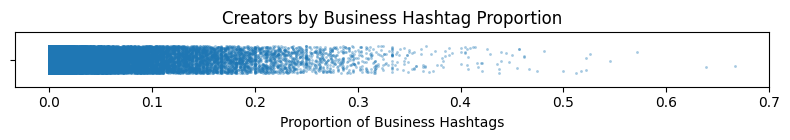

In [75]:
import seaborn as sns

plt.figure(figsize=(8,1.5))
sns.stripplot(
    x=rule_df["business_hashtag_prop"],
    size=2,
    alpha=0.4,
    jitter=0.25
)
plt.xlabel("Proportion of Business Hashtags")
plt.title("Creators by Business Hashtag Proportion")
plt.tight_layout()
plt.show()

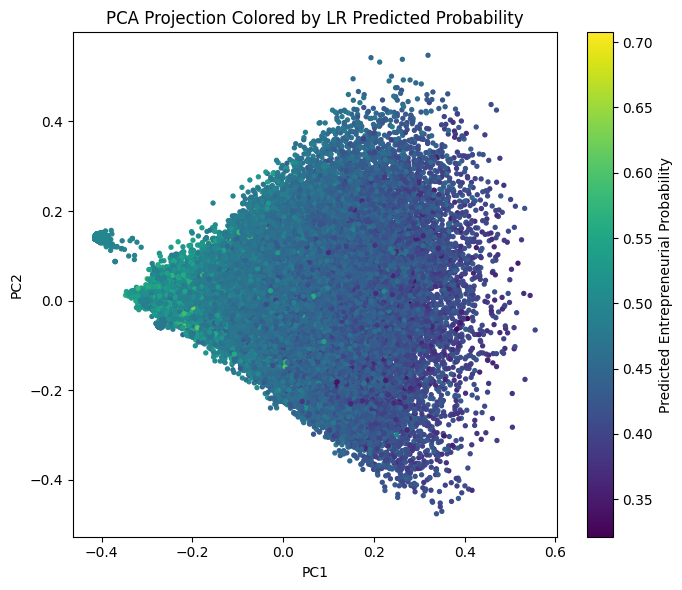

In [78]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(user_tag_tfidf.toarray())

plt.figure(figsize=(7,6))
plt.scatter(
    X_pca[:,0],
    X_pca[:,1],
    c=all_proba_lr,
    s=8
)
plt.colorbar(label="Predicted Entrepreneurial Probability")
plt.title("PCA Projection Colored by LR Predicted Probability")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()


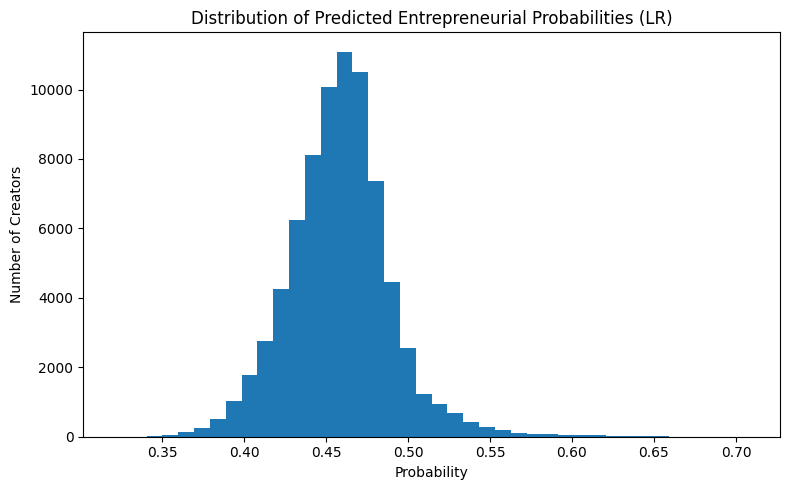

In [36]:
#see if entrepreneurial creators cluster at low, mid, or high probabilities
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(all_proba_lr, bins=40)
plt.title("Distribution of Predicted Entrepreneurial Probabilities (LR)")
plt.xlabel("Probability")
plt.ylabel("Number of Creators")
plt.tight_layout()
plt.show()


In [80]:
# 1. KMeans Clustering (Approach 1)
f1_cluster_method = f1_cluster
prec_cluster = precision_score(cluster_eval["label"], cluster_eval["pred_cluster_binary"])

# 2. Rule-Based (Approach 2)
f1_rule_method = best_f1
prec_rule = precision_score(labeled_meta_tfidf["label"], labeled_meta_tfidf["pred_rule"])

# 3. Logistic Regression on TF-IDF (Approach 3)
f1_lr_method = cv_scores.mean()    # cross-val F1
prec_lr = precision_score(y_test, y_pred_lr)
auc_lr = roc_auc_score(y_test, y_proba_lr)

# 4. Transformer Captions + Logistic Regression (Approach 4)
f1_text_method = cv_scores_text.mean()
prec_text = precision_score(y_test_t, y_pred_text)
auc_text = roc_auc_score(y_test_t, y_proba_text)

# Build performance table
performance_table = pd.DataFrame({
    "Method": [
        "KMeans Clustering (k=2)",
        "Rule-Based (Business Hashtag Prop)",
        "Logistic Regression (TF-IDF Hashtags)",
        "Logistic Regression (Transformer Captions)"
    ],
    "F1 Score": [
        f1_cluster_method,
        f1_rule_method,
        f1_lr_method,
        f1_text_method
    ],
    "Precision": [
        prec_cluster,
        prec_rule,
        prec_lr,
        prec_text
    ]
})

print("\nModel Performance Comparison (All Four Methods):")
print(performance_table.to_string(index=False))


Model Performance Comparison (All Four Methods):
                                    Method  F1 Score  Precision
                   KMeans Clustering (k=2)  0.666667   0.545455
        Rule-Based (Business Hashtag Prop)  0.750000   0.666667
     Logistic Regression (TF-IDF Hashtags)  0.613333   0.500000
Logistic Regression (Transformer Captions)  0.674719   0.714286
